In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm
import math

import utils
import train_infer_utils
from model import UNet
from config import Config
from consts import Consts

In [2]:
trans = transforms.ToTensor()
reverse_trans = transforms.ToPILImage()
train_set = datasets.MNIST("data", train=True, download=True, transform=trans)
test_set = datasets.MNIST("data", train=False, download=True, transform=trans)

In [3]:
train_loader = DataLoader(train_set, batch_size=Config.batch_size, 
    shuffle=True, num_workers=4)

test_loader = DataLoader(test_set, batch_size=Config.batch_size, 
    shuffle=True, num_workers=4)

print(len(train_set))

60000


torch.Size([64, 1, 28, 28])
(28, 28)


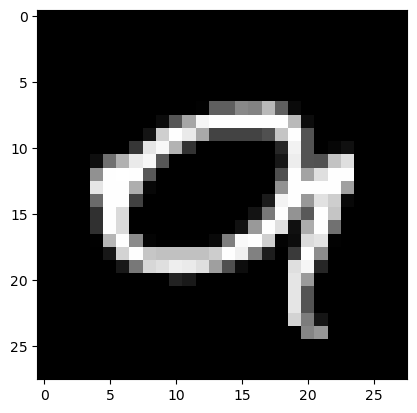

In [4]:
for (X, y) in train_loader:
    print(X.size())
    X = X[0]

    img = reverse_trans(X)
    print(img.size)
    plt.imshow(img, cmap='gray')
    break

In [5]:
for (X, y) in train_loader:
    X = X[0]
    imgs = [train_infer_utils.get_noisy_image(X, torch.tensor([t])) for t in [0, 50, 100, 150, 199]]
    imgs = list(map(lambda img : reverse_trans(img), imgs))
    print(imgs[0].size)
    utils.plot(imgs, cmap ='gray')
    break

(28, 28)


In [6]:
model = UNet(Config.channels, Config.channels, Config.time_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=Config.lr)
device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device)

UNet(
  (time_embedding): TimeEmbedding(
    (time_embedding): Sequential(
      (0): Linear(in_features=28, out_features=112, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=112, out_features=112, bias=True)
    )
  )
  (in_conv): InConv(
    (in_conv): ResidualDoubleConvBlock(
      (conv1): ConvBlock(
        (conv): Sequential(
          (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (conv2): ConvBlock(
        (conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (mlp): Sequential(
        (0): SiLU()
        (1): Linear(in_features=112, out_features=64, bias=True)
      )
      (res

In [7]:
sum_img = 0
torch.autograd.set_detect_anomaly(True)
for epoch in range(Config.epochs):
    for (X, y) in train_loader:
        optimizer.zero_grad()
        X = X.to(device)

        step = torch.randint(0, Config.timesteps, (Config.batch_size,), device=device)
        loss = train_infer_utils.diff_loss(X, step, model)

        loss.backward()
        optimizer.step()

        sum_img += Config.batch_size
        print(f"{sum_img : 7d} : {loss.item() * 100 : .3f}%")
        if sum_img >= 1000:
            break

     64 :  59.406%
    128 :  31.601%
    192 :  23.610%
    256 :  17.074%
    320 :  12.628%
    384 :  10.257%
    448 :  9.635%
    512 :  10.291%
    576 :  10.111%
    640 :  9.164%
    704 :  8.105%
    768 :  8.535%
    832 :  6.724%
    896 :  7.188%
    960 :  6.038%
   1024 :  7.306%


In [8]:
torch.save(model.state_dict(), Config.model_path)